<a href="https://colab.research.google.com/github/vaibhatt/Hackfest-IIT-ISM-Dhanbad-2021-/blob/master/Copy_of_IMAGE_CAPTIONING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NOTEBOOK TO DEVELOP AN IMAGE CAPTIONING MODEL

This notebook is intented to develop a model which will take in as input an image and output the captions from it, that is to say, it will describe the differnet objects present in the image.


**MOUNTING GDRIVE ONTO THE NOTEBOOK**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
COLAB = True

Mounted at /content/drive


**IMPORTING NECCESSARY LIBRARIES**

In [ ]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

ROOT_CAPTIONING WILL HOLD THE ROOT ADDRESS OF ALL THE FILES AND FOLDERS BEING USED IN THIS NOTEBOOK

#DATASETS NEEDED

For the development of this project the Flickr8k dataset has been used to trai the images against captions.It is an open-source dataset containing 8k
images each with at least one object. Corresponding to each image we have a captions that accurately describes the image. The captions are stores in the Folder Flickr8k_text->Flickr8k.token.txt.This tokens data contains upto 5 captions for each image [resent in the Fliker8k_image dataset.

Along with flickr8k datset we also used the glove.6B dataset which stores the vector representation of common words we encounter in our day-to-day life.

In [ ]:
root_captioning="/content/drive/MyDrive/Colab Notebooks/CAPTIONING"

#PREPARING THE DATASET
Each image in the dataset contains upto 5 captions associated with it.these captions are strings which may have uneccessary punctuations and/or spaces in between. We must clean these irregularities.
We also prepare a dictionary,lookup, where each entry contains the list of all the image caption captions for a particular image index.
The lex set contains all the unique words present in the tokens dataset. 

In [ ]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text','Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [ ]:
print(len(lookup)) # The length of the dictionary
print(len(lex)) # How many unique words
print(max_length) # Maximum length of a caption (in words)


8092
8763
32


#FINDING PATH TO THE IMAGES

the glob module defined below is ued to find path to all the images present in the Flicker8k_Datset


In [ ]:
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [ ]:
print(len(img))
img[0:5]#printing the addresses of the first 5 images

8166


['/content/drive/MyDrive/Colab Notebooks/CAPTIONING/Flicker8k_Dataset/3282634762_2650d0088a.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CAPTIONING/Flicker8k_Dataset/3273403495_fcd09c453e.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CAPTIONING/Flicker8k_Dataset/2483993772_f64e9e4724.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CAPTIONING/Flicker8k_Dataset/3563461991_de05537878.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CAPTIONING/Flicker8k_Dataset/1020651753_06077ec457.jpg']

In [ ]:
train_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))#STORES THE ADDRESS OF ALL THE TRAIN IMAGES
test_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n')) #STORES THE ADDRESS OF ALL THE TEST IMAGES

train_img = [] #stores the train addresses in a list
test_img = [] #stores the test addresses in a lis

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

In [ ]:
print(len(train_images))#stores the addresses of all the train images
print(len(test_images))#stores the addresses of all the test images

6000
1000


BUILDING A DICTIONARY FOR STORING THE TRAIN IMAGES ALONG WITH ITS CAPTIONS. WE ALSO ADD A SPECIAL START AND END TOKEN IN THE BEGINNING/END SO AS TO KNOW WHEN TO START A CAPTION AND WHEN TO FINISH IT

In [ ]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [ ]:
print(len(train_descriptions))

6000


#EXTRACTING FEATURES FROM IMAGES
THE IMAGES TO BE PASSED TO THE CAPTIONING MODEL CANNOT BE RAW IMAGES, WE HAVE TO EXTRACT THE FEATURES FROM EACH OF THESE IMAGES AN THEN PASS IT ONTO THE CAPTIONING MODEL.FOR DOING THIS WE USE THE PRE-TRAINED INCEPTIONV3 CNN MODEL.
THIS FORMS OUR ENCODING MODEL.WITHOUT THE USE OF SUCH PRE-BUILD MODELS THE IMAGES WILL TAKE IN SIGNIFICANTLY MORE TRAINING.

In [ ]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

In [ ]:
encode_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

THIS FUNCTION TAKES IN A RAW IMAGE AND OUTPUTS THE FEATURES EXTRACTED FROM THEM, SO AS TO BE USED FOR LATER MODELS

In [ ]:
def encodeImage(img):
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = encode_model.predict(x)
  x = np.reshape(x, OUTPUT_DIM )
  return x

#STORING THE FEATURES FOR THE TRAIN IMAGES

WE USE THE PICKLE LIBRARY TO STORE THE TRAINING IMAGES ID ALONG WITH ITS EXTRACTED FEATURES IN THE FORM OF A DICTIONARY. DOING THIS WILL SAVE US A LOT OF TIME LATER AND ALSO PREVENT US FROM RE-EXTRACTTING THE SAME FEATURES IF A SITUATION OF RE-TRAINING OCCURS

In [ ]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img): #iterating the traing images by using the tqdm function so that the iteartion shows a smart progress meter also.
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path,target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

#STORING FEATURES FOR TEST IMAGES

SAME AS WE DID FOR THE TRAIN IMAGES, WE ALSO STORE THE FEATURES FOR THE TEST IMAGES INTO PICKLE FILE FOR LATER USE

In [ ]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path,target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

WE SEPRATE CAPTIONS FROM THE IMAGES, THERE ARE TWO SIDE OF TRAINING THE MODEL,ONE ON IMAGES AND THE OTHER ON CAPTIONS

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

LESS COMMON WORDS CAN BE BE MISLEADING TO THE NEURAL NETWORK BEING TRAINED, SO WE REMOVE ANY WORD WHICH OCCURS LESS THAN 10 TIMES AND PREPARE A RESULTING VOCABULARY

In [ ]:
word_count_threshold = 10
word_counts = {} #STORES THE NUMBER OF TIMES EACH WORD HAS OCCURED IN THE CAPTIONS TRAINING LIST
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]# VOCAB STORES ONLY THOSE WORDS WHICK OCCUR MORE THAN 10 TIMES
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


NOW WE PREPARE TWO DICTIONARIES FOR THE VOCAB, THE IDXTOWORD DICT ASSCOIATES THE INDEX TO CORRESPONDING WORDS PRESENT IN THE VOCAB LIST . TH WORDTOIDX DOES THE OPPOSITE.

In [ ]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size


1652

#STORING THE DICTIONARIES

WE NOW STORE THE IDXTOWORD AND THE WORDTOIDX DICTIONARIES INTO THE GDRIVE IN THE FORM OF PICKLE FILES.THESE WILL BE USED LATER FOR PREDICTING THE RESULTS.

In [ ]:
idxtoword_path=os.path.join(root_captioning,"data",'idxtoword.pkl')
with open(idxtoword_path, "wb") as fp:
  pickle.dump(idxtoword, fp)
print("data saved")

data saved


In [ ]:
wordtoidx_path=os.path.join(root_captioning,"data",'wordtoidx.pkl')
with open(wordtoidx_path, "wb") as fp:
  pickle.dump(wordtoidx,fp)
print("data saved")

data saved


In [ ]:
max_length +=2
print(max_length)

34


#USING DATA GENERATORS

Up to this point, we've always generated training data ahead of time and fit the neural network to it. It is not always practical to create all of the training data ahead of time. The memory demands can be considerable. If we generate the training data as the neural network needs it, it is possible to use a Keras generator. The generator will create new data as it is needed. The generator provided here creates the training data for the caption neural network, as it is needed.

In [ ]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each caption into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

GLOVE IS AN UNSUPERVISED LEARNING ALGORITHM FOR OBTAINING THE VECTOR REPRESENTATION OF THE WORDS. THESE VECTORS ARE GLOBAL IN NATURE AND ARE USED FOR TRAININGS MODELS WHICH TAKE IN WORDS(TEXT) AS INPUT.

In [ ]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:23, 16940.93it/s]

Found 400000 word vectors.


#CREATING EMBEDDING MATRIX
NOW WE USE THE GLOVE EMBEDDINGS TO CREATE A 200 DIM VECTOR FOR EACH WORD PRESENT IN OUR VOCABULARY. WE STORE THESE IN A MATRIX CALLED EMBEDDING MATRIX

In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each word in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

#CREATING THE CAPTION MODEL

NEXT WE HAVE TO CREATE THE CAPTION MODEL, THIS MODEL TAKES IN AS INPUT AN IMAGE AND OUTPUTS THE PREDICTED CAPTION

In [ ]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
embedding_dim

200

In [ ]:
caption_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

#TRAINING THE CAPTION MODEL

In [ ]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)
    



#FUNCTION TO OUTPUT THE RESULT

THE GENERATECAPTION FUNCTION IS USED TO TAKE A ENCODED IMAGE AND OUTPUT THE PREDICTED CAPTIONS.

In [ ]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

#TESTING THE DATA

NOW WE TEST THE MODEL AGAINST A FEW OF THE TRAIN IMAGES

/content/drive/MyDrive/Colab Notebooks/CAPTIONING/Flicker8k_Dataset/3192266178_f9bf5d3dba.jpg


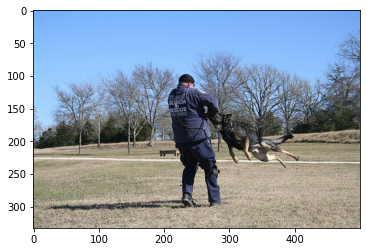

Caption: man in blue shirt is playing with dog in the grass
_____________________________________
/content/drive/MyDrive/Colab Notebooks/CAPTIONING/Flicker8k_Dataset/3234115903_f4dfc8fc75.jpg


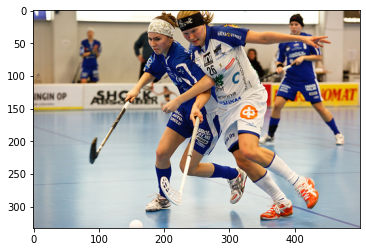

Caption: two men in martial arts match
_____________________________________


In [ ]:
for z in range(2): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [ ]:
encoding_test[pic].shape

(2048,)